# TRM
Have you ever thought about automating repetitive tasks?
so we have Task Recommender Machine (TRM) for you :)) 

thats powerd by reletivly big data and recurrent neural networks

In [1]:
# imports as always 
import sys
import pandas as pd
import datetime
from datetime import datetime
from datetime import timedelta
import time
import random
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore')

## time sampling
time sampling for a person that she started her job at 09/01/2022 and workin 9 hours a day with some taskes 

## Helper Functions for time sampling 

In [2]:
def toTimeSpace(string,start = '00:00:00'):
    # string type is  "%m/%d/%Y %H:%M:%S"
    start_minutes = datetime.strptime(start, '%H:%M:%S').minute + datetime.strptime(start, '%H:%M:%S').hour * 60
    splited = string.split()
    day = splited[0]
    clock = splited[1]
    splited = clock.split(':')
    hour = splited[0]
    minute = splited[1]
    second = splited[2]
    #score = 60 * (int(splited[0]) - datetime.strptime(start, '%H:%M:%S').hour ) + int(splited[1])
    score = (60 * int(hour) + int(minute)) - start_minutes
    return score

In [3]:
def idGenerator(num):
    bias = 1000
    array = np.arange(0,num) + bias
    array = array.astype(int)
    return array

In [4]:
def clock(string,worksPerDay = 9,start = '09:00:00',stop = '18:00:00'):
    #-----------------------------------------------------------------
    datetime_object = datetime.strptime(string, '%m/%d/%Y %H:%M:%S')
    #-----------------------------------------------------------------
    stop_minutes = datetime.strptime(stop, '%H:%M:%S').minute + datetime.strptime(stop, '%H:%M:%S').hour * 60
    start_minutes = datetime.strptime(start, '%H:%M:%S').minute + datetime.strptime(start, '%H:%M:%S').hour * 60
    #-----------------------------------------------------------------
    rdn = random.randint(1,int((stop_minutes - start_minutes)/worksPerDay))
    value = datetime_object + timedelta(minutes = rdn)
    if value.hour >= datetime.strptime(stop, '%H:%M:%S').hour :
        value = value - timedelta(minutes = value.minute)
        value = value + timedelta(hours = 15)
        datetime_object = value
    else:
       datetime_object = value
       
    if value.strftime('%a') =='Fri':
        datetime_object = datetime_object - timedelta(minutes = value.minute)
        datetime_object = datetime_object + timedelta(days = 1)   
    #-----------------------------------------------------------------
    return(datetime_object.strftime("%m/%d/%Y %H:%M:%S"))

## dictionary contains all paths(work's)

In [5]:
#dictionary contains all paths that you can add or remove 
dirs = {'/Desktop/folder9','/Desktop/folder8','/Desktop/folder1','/Desktop/folder2','/Desktop/folder3','/Desktop/folder4','/Desktop/folder5','/Desktop/folder6','/Desktop/data/folder7'}
dirs = list(dirs)
dirs[random.randint(0,len(dirs)-1)].split("/")[-1]

'folder1'

In [6]:
def sampling(persons,worksPerDay,lenOfData):
    data = pd.DataFrame({'id': [0],'time' : [0],'log' : ['/']})
    ids = iter(idGenerator(lenOfData))
    #-----------------------------------------------------
    for i in range(persons):
        worksPerDay = int(np.random.normal(worksPerDay, 0.3, 1))
        init = '09/01/2022 09:00:00'
        thisId = next(ids)
        df = pd.DataFrame({'id': thisId,'time' : [init],'log' : dirs[random.randint(0,len(dirs)-1)].split("/")[-1]})
        for j in range(int(lenOfData/persons)):
            init = clock(init,worksPerDay)
            df_new = pd.DataFrame({'id': thisId,'time' : [init],'log' : dirs[random.randint(0,len(dirs)-1)].split("/")[-1]})
            df = pd.concat([df,df_new], ignore_index = True)
        data = pd.concat([data,df], ignore_index = True)
    #-----------------------------------------------------
    #dropping first row and re indexing
    data.drop(index=(0),inplace=True)
    data.index = data.index -1 

    data.sort_values(by='time',inplace=True)
    data.index = np.arange(0,len(data))
    
    for i in range(len(data) - lenOfData):
        data.drop(index=(len(data)-1),inplace=True)
    
    #saving data to file in csv 
    data.to_csv('data.csv', index=True) 
    return data


In [7]:
#runing sampling code and write it's return to CSV
sampling(persons = 10,worksPerDay = 12,lenOfData = 600)

,id,time,log
0,1000,09/01/2022 09:00:00,folder9
1,1002,09/01/2022 09:00:00,folder8
2,1003,09/01/2022 09:00:00,folder4
3,1009,09/01/2022 09:00:00,folder6
4,1005,09/01/2022 09:00:00,folder2
...,...,...,...
595,1008,09/04/2022 14:30:00,folder8
596,1009,09/04/2022 14:40:00,folder7
597,1000,09/04/2022 14:45:00,folder6
598,1000,09/04/2022 14:51:00,folder9


# no time base data for TRM

In this part, the time of doing the work is not important, the order of doing the work is important In such a way that any work is recommended immediately after the previous work

In [8]:
#loading data from CSV
data = pd.read_csv('data.csv') 
data.drop(columns=('Unnamed: 0'),inplace=True)
data

,id,time,log
0,1000,09/01/2022 09:00:00,folder9
1,1002,09/01/2022 09:00:00,folder8
2,1003,09/01/2022 09:00:00,folder4
3,1009,09/01/2022 09:00:00,folder6
4,1005,09/01/2022 09:00:00,folder2
...,...,...,...
595,1008,09/04/2022 14:30:00,folder8
596,1009,09/04/2022 14:40:00,folder7
597,1000,09/04/2022 14:45:00,folder6
598,1000,09/04/2022 14:51:00,folder9


## Data Preprocessing

### Helper Functions

In [9]:
def timeFormater(string):
    # remove '[' and %d/%b/%Y:%H:%M:%S to %m/%d/%Y %H:%M:%S string to string
    try:
        string = string.replace('[', '')
        stringToDate = datetime.strptime(string, "%d/%b/%Y:%H:%M:%S")
        string = stringToDate.strftime('%m/%d/%Y %H:%M:%S')
        return string
    except:
        return '?'

In [10]:
def toTimeStamp(string):
    return time.mktime(datetime.strptime(string,"%m/%d/%Y %H:%M:%S").timetuple())

### Data Preprocessing

In [11]:
data = pd.read_csv('weblog.csv')  #loading dataset
data.rename(columns={"URL": "log", "IP": "id","Time": "time"},inplace=True) 
data.drop(['Staus'], axis=1,inplace=True) # we dont need that right now !
#------------------------------------------------------------------------
shouldRemove = data['id'].value_counts()[data['id'].value_counts() < 100] #removing Chert!! ids :))
for i in range(len(shouldRemove)):
    data.drop(data.loc[data['id'] == shouldRemove.index[i]].index,inplace=True)# it Automaticly delete's time missing values
#------------------------------------------------------------------------
data['time'] = data ['time'].apply(timeFormater) #changing time format to smother one
data['timestamp'] = data ['time'].apply(toTimeStamp) #time stamp for best sorting by time
data.sort_values(by='timestamp',ascending=True,inplace=True) #sorting by time
data.drop(['timestamp'], axis=1,inplace=True) #removing time stamp , we dont need that anymore !
#------------------------------------------------------------------------
data.reset_index(inplace=True) #reset index 
data.drop(['index'], axis=1,inplace=True)#remove old index 
data

,id,time,log
0,10.130.2.1,11/07/2017 23:59:19,GET / HTTP/1.1
1,10.130.2.1,11/07/2017 23:59:19,GET / HTTP/1.1
2,10.129.2.1,11/08/2017 00:39:07,GET / HTTP/1.1
3,10.129.2.1,11/08/2017 00:39:07,GET /login.php HTTP/1.1
4,10.129.2.1,11/08/2017 00:39:07,GET /login.php HTTP/1.1
...,...,...,...
15784,10.130.2.1,03/02/2018 15:47:12,GET /showcode.php?id=309&nm=ham05 HTTP/1.1
15785,10.130.2.1,03/02/2018 15:47:23,GET /allsubmission.php HTTP/1.1
15786,10.130.2.1,03/02/2018 15:47:32,GET /showcode.php?id=309&nm=ham05 HTTP/1.1
15787,10.130.2.1,03/02/2018 15:47:35,GET /allsubmission.php HTTP/1.1


In [12]:
startDate = data.loc[0]['time']
startDate

'11/07/2017 23:59:19'

In [13]:
data.loc[data['id'] == '10.130.2.1']

,id,time,log
0,10.130.2.1,11/07/2017 23:59:19,GET / HTTP/1.1
1,10.130.2.1,11/07/2017 23:59:19,GET / HTTP/1.1
16,10.130.2.1,11/08/2017 05:01:24,GET /login.php HTTP/1.1
17,10.130.2.1,11/08/2017 05:01:24,GET /login.php HTTP/1.1
50,10.130.2.1,11/08/2017 15:56:23,GET / HTTP/1.1
...,...,...,...
15784,10.130.2.1,03/02/2018 15:47:12,GET /showcode.php?id=309&nm=ham05 HTTP/1.1
15785,10.130.2.1,03/02/2018 15:47:23,GET /allsubmission.php HTTP/1.1
15786,10.130.2.1,03/02/2018 15:47:32,GET /showcode.php?id=309&nm=ham05 HTTP/1.1
15787,10.130.2.1,03/02/2018 15:47:35,GET /allsubmission.php HTTP/1.1


# Some helper functions

In [14]:
def toDays(date,startDate='11/07/2017 9:00:00'):
    #it takes a date and give us how many mitunes away from everyday starting date 
    date = datetime.strptime(date, '%m/%d/%Y %H:%M:%S')
    startDate = datetime.strptime(startDate, '%m/%d/%Y %H:%M:%S')
    return (date.year - startDate.year) * 366 + (date.month - startDate.month) * 31 + (date.day - startDate.day)

In [15]:
def weekDay(datetime_str):
    #it takes a date and give us weekDay! like Mon,Thu,Wed
    date = datetime.strptime(datetime_str, '%m/%d/%Y %H:%M:%S')
    return date.strftime("%a")

In [16]:
toDays('11/09/2017 23:59:19')

2

# Feature extraction

In [17]:
# TimeSerious feature
dayArray = data['time'].apply(toDays)
uniqueDayArray = np.array(dayArray.unique())
asignedArray = np.arange(0,len(uniqueDayArray))
for i in range(len(uniqueDayArray)):
        dayArray[dayArray == uniqueDayArray[i]] = asignedArray[i]
data['day'] = dayArray
#-----------------------------------------------------
#it takes a date and give us weekDay! like Mon,Thu,Wed
data['weekday'] = data ['time'].apply(weekDay) 
#-----------------------------------------------------
data['timeSerious'] = data ['time'].apply(toTimeSpace)
#-----------------------------------------------------
data

,id,time,log,day,weekday,timeSerious
0,10.130.2.1,11/07/2017 23:59:19,GET / HTTP/1.1,0,Tue,1439
1,10.130.2.1,11/07/2017 23:59:19,GET / HTTP/1.1,0,Tue,1439
2,10.129.2.1,11/08/2017 00:39:07,GET / HTTP/1.1,1,Wed,39
3,10.129.2.1,11/08/2017 00:39:07,GET /login.php HTTP/1.1,1,Wed,39
4,10.129.2.1,11/08/2017 00:39:07,GET /login.php HTTP/1.1,1,Wed,39
...,...,...,...,...,...,...
15784,10.130.2.1,03/02/2018 15:47:12,GET /showcode.php?id=309&nm=ham05 HTTP/1.1,56,Fri,947
15785,10.130.2.1,03/02/2018 15:47:23,GET /allsubmission.php HTTP/1.1,56,Fri,947
15786,10.130.2.1,03/02/2018 15:47:32,GET /showcode.php?id=309&nm=ham05 HTTP/1.1,56,Fri,947
15787,10.130.2.1,03/02/2018 15:47:35,GET /allsubmission.php HTTP/1.1,56,Fri,947


In [18]:
data['timeSerious'].min()

0

In [19]:
data['timeSerious'].max() #1439 minuts is about 23:59 past from 00:00

1439

In [20]:
# WorkToNum feature
allWorks = np.array(data['log'].unique())
#-----------------------------------------------------
rangeVector = np.arange(1,len(allWorks)+1)
#-----------------------------------------------------
dictionary = {}
for i in range(len(allWorks)):
    dictionary[allWorks[i]] = rangeVector[i]
#-----------------------------------------------------
def workToNum(string):
    return dictionary[string]
#-----------------------------------------------------
data['workToNum'] = data['log'].apply(workToNum)
#-----------------------------------------------------
data.drop('log', axis='columns',inplace=True)
data.drop('time', axis='columns',inplace=True)

In [21]:
# WeekToNum feature
allWeeks = np.array(data['weekday'].unique())
#-----------------------------------------------------
rangeVector = np.arange(1,len(allWeeks)+1)
#-----------------------------------------------------
WeeksDictionary = {}
for i in range(len(allWeeks)):
    WeeksDictionary[allWeeks[i]] = rangeVector[i]
#-----------------------------------------------------
def weekToNum(string):
    return WeeksDictionary[string]
#-----------------------------------------------------
data['weekToNum'] = data['weekday'].apply(weekToNum)
data.drop('weekday', axis='columns',inplace=True)

In [22]:
d = data.loc[data['id']=='10.130.2.1']
d.loc[d['day'] == 40]

,id,day,timeSerious,workToNum,weekToNum
9351,10.130.2.1,40,1217,7,7
9353,10.130.2.1,40,1217,2,7
9354,10.130.2.1,40,1217,10,7
9363,10.130.2.1,40,1217,7,7
9364,10.130.2.1,40,1217,7,7
...,...,...,...,...,...
14425,10.130.2.1,40,1256,2,7
14434,10.130.2.1,40,1256,7,7
14435,10.130.2.1,40,1256,2,7
14436,10.130.2.1,40,1256,7,7


# Data analyst tools make data even more appropriate

In [23]:
def plotTimeLine(id = '10.130.2.1' , day= 21):
    d = data.loc[data['id']==id]
    arr = d.loc[d['day'] == day]['timeSerious'].to_numpy()
    unique, counts = np.unique(arr, return_counts=True)
    mass = np.arange(0,1440)
    lineSpace = np.zeros((1440))
    lineSpace[unique] = counts
    fig = plt.figure(figsize = (25, 10))
    # creating the bar plot
    plt.bar(mass, lineSpace, color ='red',width = 0.4)

In [24]:
data

,id,day,timeSerious,workToNum,weekToNum
0,10.130.2.1,0,1439,1,1
1,10.130.2.1,0,1439,1,1
2,10.129.2.1,1,39,1,2
3,10.129.2.1,1,39,2,2
4,10.129.2.1,1,39,2,2
...,...,...,...,...,...
15784,10.130.2.1,56,947,292,4
15785,10.130.2.1,56,947,25,4
15786,10.130.2.1,56,947,292,4
15787,10.130.2.1,56,947,25,4


In [25]:
data.loc[data['id']=='10.131.1.1']['day'].value_counts()

Series([], Name: day, dtype: int64)

In [26]:
# plotTimeLine(id = '10.131.2.1',day= 40)

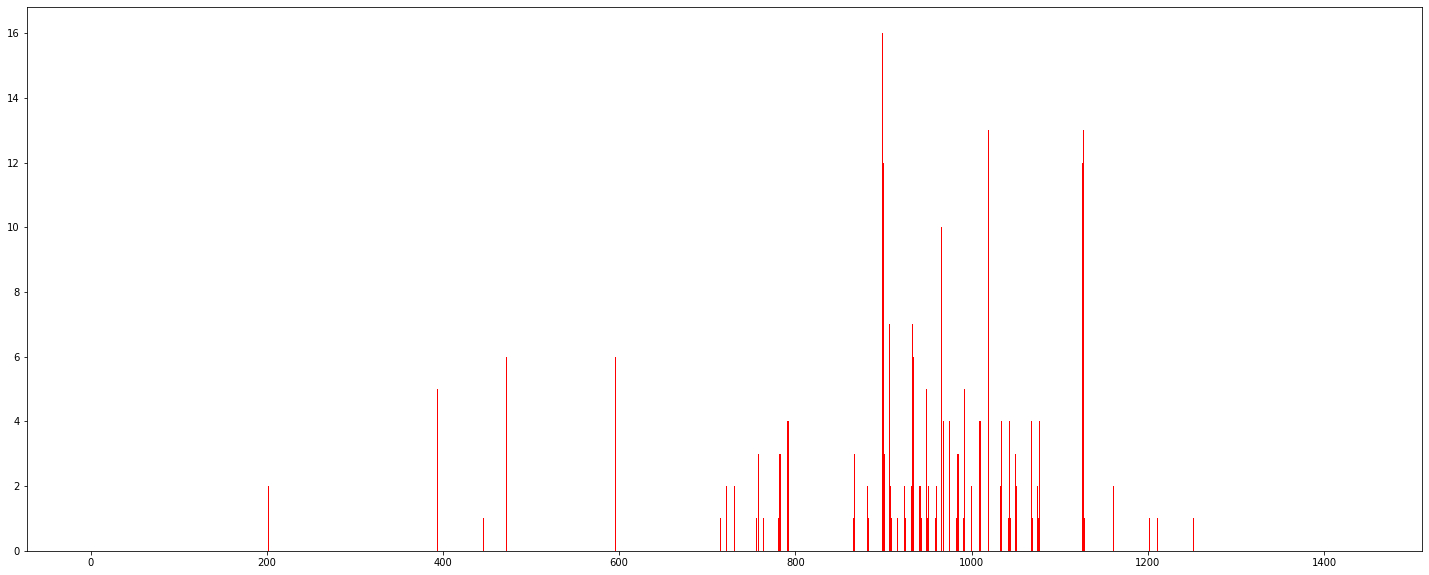

In [27]:
plotTimeLine(id = '10.131.2.1',day= 21)

In [28]:
# it seems that you should delete days 40th and 21th for id :'10.130.2.1' !!
data.drop(data.loc[(data['id']=='10.130.2.1')&(data['day']==40)].index,inplace=True)
data.drop(data.loc[(data['id']=='10.130.2.1')&(data['day']==21)].index,inplace=True)
# it seems that you should delete day 21th for id :'10.129.2.1' !!
data.drop(data.loc[(data['id']=='10.129.2.1')&(data['day']==21)].index,inplace=True)
# it seems that you should delete days 40th and 21th for id :'10.128.2.1' !!
data.drop(data.loc[(data['id']=='10.128.2.1')&(data['day']==40)].index,inplace=True)
data.drop(data.loc[(data['id']=='10.128.2.1')&(data['day']==21)].index,inplace=True)
# it seems that you should delete days 40th and 21th for id :'10.128.2.1' !!
data.drop(data.loc[(data['id']=='10.128.2.1')&(data['day']==40)].index,inplace=True)
data.drop(data.loc[(data['id']=='10.128.2.1')&(data['day']==21)].index,inplace=True)
# it seems that you should delete days 40th and 21th for id :'10.128.2.1' !!
data.drop(data.loc[(data['id']=='10.131.0.1')&(data['day']==40)].index,inplace=True)
data.drop(data.loc[(data['id']=='10.131.0.1')&(data['day']==21)].index,inplace=True)
# it seems that you should delete day 21th for id :'10.129.2.1' !!
data.drop(data.loc[(data['id']=='10.131.2.1')&(data['day']==21)].index,inplace=True)

## Pandas Data Frame to numpy matrix for training data
that's achive four parameters: <br>
1 - number of all persons (unique ids) <br>
2 - number of data's (diffrent days) of each persons <br>
3 - number of all possible works (len of workToVec) <br>
4 - maximum of number of works in all days <br>

## Padding functions
make a padding to np arrays for instance: <br>
maxlen = 4 <br>
array = [2,3] <br>
new array = [2,3,0,0] <br>

In [29]:
def vectorPadding(array,maxlen):
    newArray = np.zeros((1,maxlen))
    newArray = newArray[0]
    newArray[0:len(array)] = array
    newArray = newArray.astype(int)
    return newArray

## Onehot functions

In [30]:
def vecToOneHot(vec,max):
    oh = np.zeros((vec.size, max))
    oh[np.arange(vec.size), vec] = 1
    return oh

In [31]:
def matToOneHot(vec,type = 'work'):
    numberOfVecs = vec.shape[0] #number of vectors
    lenOfVecs = vec.shape[1] #len of each vector
     # len of onehot matrix
    if type =='week':
        lenOfOh = 8 # correspond to 7 days of week + 1 for null days
    else :  
        lenOfOh = vec.max() + 1  
    #---------------------------------------------
    mat = np.zeros((lenOfVecs,lenOfOh)) # matrix !
    #---------------------------------------------
    for n in range(numberOfVecs):
        mat = np.concatenate((mat,vecToOneHot(vec[n] ,lenOfOh)))
        #-----------------------------------------
    mat = mat[lenOfVecs:]
    mat = mat.reshape(numberOfVecs,lenOfVecs,lenOfOh)
    return mat

## Put all together and Saving Data to a file

In [32]:
Persons = data['id'].unique() # array of all unique ids in other hand array of all diffrent persons
lenPersons = len(data['id'].unique()) # number of all unique ids in other hand number of all diffrent persons
workToNumLen = max(data['workToNum']) #number of all possible works
#------------------------------------------------------------------
for idx in range(lenPersons):
    currentId = Persons[idx]
    numOfDays = len(data.loc[data['id'] == currentId]['day'].unique()) # number of days that one person have in other hands #of All training data for one person
    days = data.loc[data['id'] == currentId]['day'].unique()
    inputSize = max(data.loc[data['id'] == currentId]['day'].value_counts())#inputSize is size of architecture of # of RNN blocks (maximum of number of works in all days)
    #--------------------------------------------------------------
    RnnWorkData = np.zeros((numOfDays,inputSize))
    RnnWeekData = np.zeros((numOfDays,inputSize))
    #--------------------------------------------------------------
    for i in range(len(days)):
        temp = data.loc[(data['id'] == currentId) & (data['day'] == days[i])] 
        workToNumVector = temp['workToNum'].to_numpy()
        workToNumVector = vectorPadding(workToNumVector,inputSize)
        weekToNumVector = temp['weekToNum'].to_numpy()
        weekToNumVector  = vectorPadding(weekToNumVector,inputSize)
        #----------------------------------------------------------
        RnnWorkData[i,:] = workToNumVector
        RnnWeekData[i,:] = weekToNumVector
        #print(workToNumVector)            # do not Delete!!
    #--------------------------------------------------------------
    RnnWorkDataOH = matToOneHot(RnnWorkData.astype(int)) # transforming scalar numbers to onehot
    RnnWeekDataOH = matToOneHot(RnnWeekData.astype(int),type='week') # transforming scalar numbers to onehot
    #--------------------------------------------------------------
    print('RnnWorkDataOH.shape => ' +str(RnnWorkDataOH.shape))
    print('RnnWeekDataOH.shape => ' +str(RnnWeekDataOH.shape))
    #--------------------------------------------------------------
    #print('RnnWorkData =>')               # do not Delete!!
    #print(RnnWorkData.astype(int))        # do not Delete!!
    #--------------------------------------------------------------
    #print('matToOneHot(RnnWorkData) =>')  # do not Delete!!
    #print(RnnWorkDataOH )                 # do not Delete!!
    #--------------------------------------------------------------
    #print('RnnWeekData =>')               # do not Delete!! 
    #print(RnnWeekData.astype(int))        # do not Delete!!
    #--------------------------------------------------------------
    #print('matToOneHot(RnnWeekData) =>')  # do not Delete!!
    #print(RnnWeekDataOH )                 # do not Delete!!
    #--------------------------------------------------------------
    with open('data/no_time_base/RnnWorkDataOH_id:'+str(currentId)+'.npy', 'wb') as f:
        np.save(f,RnnWorkDataOH)
    print('saved as '+'RnnWorkData_id:'+str(currentId)+'.npy')    
    with open('data/no_time_base/RnnWeekDataOH_id:'+str(currentId)+'.npy', 'wb') as f:
        np.save(f,RnnWeekDataOH)
    print('saved as '+'RnnWeekDataOH_id:'+str(currentId)+'.npy')   
    print('=======================================')

RnnWorkDataOH.shape => (55, 95, 293)
RnnWeekDataOH.shape => (55, 95, 8)
saved as RnnWorkData_id:10.130.2.1.npy
saved as RnnWeekDataOH_id:10.130.2.1.npy
RnnWorkDataOH.shape => (23, 124, 244)
RnnWeekDataOH.shape => (23, 124, 8)
saved as RnnWorkData_id:10.129.2.1.npy
saved as RnnWeekDataOH_id:10.129.2.1.npy
RnnWorkDataOH.shape => (54, 106, 292)
RnnWeekDataOH.shape => (54, 106, 8)
saved as RnnWorkData_id:10.128.2.1.npy
saved as RnnWeekDataOH_id:10.128.2.1.npy
RnnWorkDataOH.shape => (54, 117, 289)
RnnWeekDataOH.shape => (54, 117, 8)
saved as RnnWorkData_id:10.131.0.1.npy
saved as RnnWeekDataOH_id:10.131.0.1.npy
RnnWorkDataOH.shape => (23, 161, 243)
RnnWeekDataOH.shape => (23, 161, 8)
saved as RnnWorkData_id:10.131.2.1.npy
saved as RnnWeekDataOH_id:10.131.2.1.npy


## Loading Rnn data

In [33]:
PersonId = '10.130.2.1'
with open('data/no_time_base/RnnWorkDataOH_id:'+str(PersonId)+'.npy', 'rb') as f:
    RnnWorkDataOH = np.load(f)
    X = RnnWorkDataOH
with open('data/no_time_base/RnnWeekDataOH_id:'+str(PersonId)+'.npy', 'rb') as f:
    RnnWeekDataOH = np.load(f)
#print('RnnWorkDataOH:')    
#print(RnnWorkDataOH)
#print('RnnWeekDataOH:')
#print(RnnWeekDataOH)
# we decided to use no_time_base data ro id:# we decided to use no_time_base data ro id:10.130.2.1


# time base data for TRM

In this section, in addition to the order of doing things, the time of doing things is also important
In such a way that any work is not recommended immediately after the previous work and waits until its time comes

In [34]:
data

,id,day,timeSerious,workToNum,weekToNum
0,10.130.2.1,0,1439,1,1
1,10.130.2.1,0,1439,1,1
2,10.129.2.1,1,39,1,2
3,10.129.2.1,1,39,2,2
4,10.129.2.1,1,39,2,2
...,...,...,...,...,...
15784,10.130.2.1,56,947,292,4
15785,10.130.2.1,56,947,25,4
15786,10.130.2.1,56,947,292,4
15787,10.130.2.1,56,947,25,4


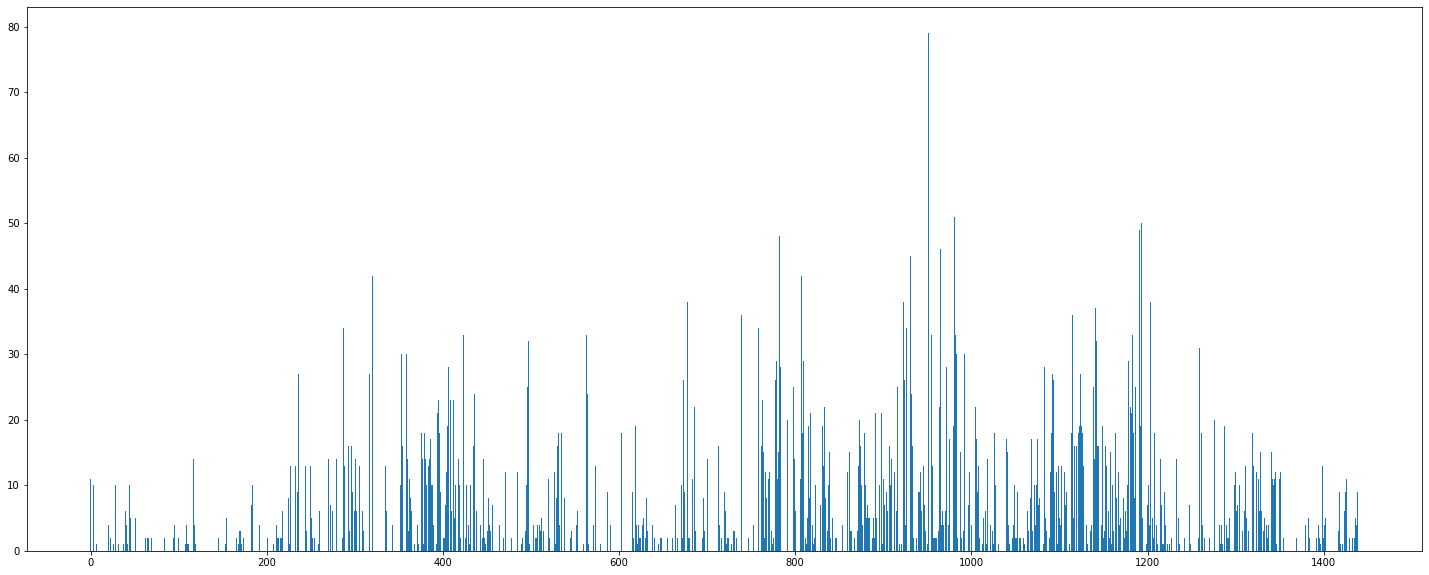

In [35]:
plotData = data['timeSerious'].value_counts()
fig = plt.figure(figsize=(25, 10))
xPlot = np.array(plotData.index)
yPlot = np.array(plotData.values)
plt.bar(xPlot,yPlot)
plt.show()

In [36]:
rnnSize = 541 #  = 9 * 60 + 1 , 540 minutes work for everyday 
rnnSize = 1440 
Persons = data['id'].unique() # array of all unique ids in other hand array of all diffrent persons
lenPersons = len(data['id'].unique()) # number of all unique ids in other hand number of all diffrent persons
#------------------------------------------------------------------
for idx in range(lenPersons):
   currentId = Persons[idx]
   numOfDays = len(data.loc[data['id'] == currentId]['day'].unique()) # #of days that one person have in other hands #of All training data for one person
   days = data.loc[data['id'] == currentId]['day'].unique()
   RnnWorkData = np.zeros((numOfDays,rnnSize),dtype=(int))
   RnnWeekData = np.zeros((numOfDays,rnnSize),dtype=(int))
   for i in range(len(days)):
         #Works : 
         oneDayRnnWorkData = np.zeros((rnnSize),dtype=int)
         temp = data.loc[(data['id'] == currentId) & (data['day'] == days[i])] 
         workIdx = temp[['timeSerious','workToNum']].to_numpy().T[0]
         workValue = temp[['timeSerious','workToNum']].to_numpy().T[1]
         oneDayRnnWorkData[workIdx] = workValue
         #Weeks :
         oneDayRnnWeekData = np.zeros((rnnSize),dtype=int)
         temp = data.loc[(data['id'] == currentId) & (data['day'] == days[i])] 
         weekIdx = temp[['timeSerious','weekToNum']].to_numpy().T[0]
         weekValue = temp[['timeSerious','weekToNum']].to_numpy().T[1]
         oneDayRnnWeekData[weekIdx] = weekValue
         #------------------------------------------------------------------
         #now adding every single days to RnnWorkData
         #Works :
         RnnWorkData[i,:] = oneDayRnnWorkData
         #Weeks :
         RnnWeekData[i,:] = oneDayRnnWeekData
         #------------------------------------------------------------------
         #Works :
         #print(workIdx)                                  # do not Delete!!
         #print(workValue)                                # do not Delete!!
         #print(oneDayRnnWorkData)                        # do not Delete!!
         #Weeks :
         #print(weekIdx)                                  # do not Delete!!
         #print(weekValue)                                # do not Delete!!
         #print(oneDayRnnWeekData)                        # do not Delete!!
         #------------------------------------------------------------------
   #now make them onehot from scaler      
   #Works :        
   RnnWorkDataOH = matToOneHot(RnnWorkData)
   #Weeks :
   RnnWeekDataOH = matToOneHot(RnnWeekData,type='week')
   #--------------------------------------------------------------------------
   #Work :
   print('RnnWorkDataOH.shape => '+str(RnnWorkDataOH.shape))    
   #print(RnnWorkDataOH[1][1])                              # do not Delete!!
   #Week :
   print('RnnWeekDataOH.shape => '+str(RnnWeekDataOH.shape))    
   #print(RnnWeekDataOH[1][2])                              # do not Delete!!
   #--------------------------------------------------------------------------
   with open('data/time_base/RnnWorkDataOH_id:'+str(currentId)+'.npy', 'wb') as f:
      np.save(f,RnnWorkDataOH)
   print('saved as '+'RnnWorkData_id:'+str(currentId)+'.npy')    
   with open('data/time_base/RnnWeekDataOH_id:'+str(currentId)+'.npy', 'wb') as f:
      np.save(f,RnnWeekDataOH)
   print('saved as '+'RnnWeekDataOH_id:'+str(currentId)+'.npy') 
   print('==================================')

RnnWorkDataOH.shape => (55, 1440, 290)
RnnWeekDataOH.shape => (55, 1440, 8)
saved as RnnWorkData_id:10.130.2.1.npy
saved as RnnWeekDataOH_id:10.130.2.1.npy
RnnWorkDataOH.shape => (23, 1440, 244)
RnnWeekDataOH.shape => (23, 1440, 8)
saved as RnnWorkData_id:10.129.2.1.npy
saved as RnnWeekDataOH_id:10.129.2.1.npy
RnnWorkDataOH.shape => (54, 1440, 291)
RnnWeekDataOH.shape => (54, 1440, 8)
saved as RnnWorkData_id:10.128.2.1.npy
saved as RnnWeekDataOH_id:10.128.2.1.npy
RnnWorkDataOH.shape => (54, 1440, 288)
RnnWeekDataOH.shape => (54, 1440, 8)
saved as RnnWorkData_id:10.131.0.1.npy
saved as RnnWeekDataOH_id:10.131.0.1.npy
RnnWorkDataOH.shape => (23, 1440, 234)
RnnWeekDataOH.shape => (23, 1440, 8)
saved as RnnWorkData_id:10.131.2.1.npy
saved as RnnWeekDataOH_id:10.131.2.1.npy


## Load Rnn Data
Load data from saved , generated data

In [37]:
PersonId = 1000
with open('data/time_base/RnnWorkDataOH_id:'+str(PersonId)+'.npy', 'rb') as f:
    RnnWorkDataOH = np.load(f)
with open('data/time_base/RnnWeekDataOH_id:'+str(PersonId)+'.npy', 'rb') as f:
    RnnWeekDataOH = np.load(f)
print('RnnWorkDataOH:')    
print(RnnWorkDataOH.shape)
#print('RnnWeekDataOH:')
#print(RnnWeekDataOH)

RnnWorkDataOH:
(3, 541, 10)


## Switchable TRM !! STRM in short


what is switchable TRM? remebmer no_time base and time base TRM.
in this phase we want to switch between them !!
but how? we can take users feedback as a data and feed to RNN to learn in wich situations we need no time base or time base model !! for example Some habits that are done at a specific time are unfortunately the result of procrastinating for example a person is used to doing one thing at a time, and if we suggest her to do that thing earlier, it might be in her favor But sometimes we may suggest something to the user that she may not want to do because she wants to rest at that time.

## STRM data sampling

In [38]:
def fakeReccomendedSequance(numOfDays = 5,jobsPerADay = 8,currentId = 1000, maxOfWorks = 10): # sampling of recommendation of no time base TRM
    m = numOfDays
    tx = jobsPerADay
    tx = int(np.random.normal(tx,0.3,1))
    tmax = maxOfWorks
    Xoh = len(dictionary)
    x = np.zeros((m,tmax,Xoh))
    y = np.zeros((m,tmax,1))
    for j in range(m):
        for i in range(tx):
            randIdx = random.randint(0,len(dictionary)-1)
            vec = vecToOneHot(np.array([randIdx]),len(dictionary))
            x[j,i,:] = vec 
            #---------------------------------------------------------------------
            label = np.random.choice([0,1], 1, p=[0.7,0.3]) # weighted random , because number of acceptation is less
            y[j,i,:] = label
            #---------------------------------------------------------------------
    print('X.shape => '+str(x.shape))     
    print('Y.shape => '+str(y.shape))        
    with open('data/switch/switchRnnXData_id:'+str(currentId)+'.npy', 'wb') as f:
        np.save(f,x)
    print('saved as '+'switchRnnXData_id:'+str(currentId)+'.npy')     
    with open('data/switch/switchRnnYData_id:'+str(currentId)+'.npy', 'wb') as f:
        np.save(f,y)
    print('saved as '+'switchRnnYData_id:'+str(currentId)+'.npy') 
    print('=========================================')    

In [39]:
Persons = data['id'].unique() # array of all unique ids in other hand array of all diffrent persons
lenPersons = len(data['id'].unique()) # number of all unique ids in other hand number of all diffrent persons
for i in range(lenPersons):
    fakeReccomendedSequance(numOfDays = 5,jobsPerADay = 8,currentId =Persons[i] , maxOfWorks = 10)

X.shape => (5, 10, 292)
Y.shape => (5, 10, 1)
saved as switchRnnXData_id:10.130.2.1.npy
saved as switchRnnYData_id:10.130.2.1.npy
X.shape => (5, 10, 292)
Y.shape => (5, 10, 1)
saved as switchRnnXData_id:10.129.2.1.npy
saved as switchRnnYData_id:10.129.2.1.npy
X.shape => (5, 10, 292)
Y.shape => (5, 10, 1)
saved as switchRnnXData_id:10.128.2.1.npy
saved as switchRnnYData_id:10.128.2.1.npy
X.shape => (5, 10, 292)
Y.shape => (5, 10, 1)
saved as switchRnnXData_id:10.131.0.1.npy
saved as switchRnnYData_id:10.131.0.1.npy
X.shape => (5, 10, 292)
Y.shape => (5, 10, 1)
saved as switchRnnXData_id:10.131.2.1.npy
saved as switchRnnYData_id:10.131.2.1.npy


In [40]:
currentId = '10.128.2.1'
with open('data/switch/switchRnnXData_id:'+str(currentId)+'.npy', 'rb') as f:
        switchRnnXDataX = np.load(f)
with open('data/switch/switchRnnYData_id:'+str(currentId)+'.npy', 'rb') as f:
        switchRnnYDataY = np.load(f)
print('switchRnnXDataX:')               
print(switchRnnXDataX)
print('--------------------------------')
print('switchRnnYDataY:')  
print(switchRnnYDataY)

switchRnnXDataX:
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
--------------------------------
switchRnnYDataY:
[[[1.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [1.]
  [1.]

# A partial insight into our Architecture

![Alt text](images/generative%20_lstm.png)

That is our TRM diagram that can use for no_time base and time base TRM

In our STRM first we should train both no_time base and time base models with particular data thet you have seen before in last part . after that we can use our no_time base TRM in test phase wich recommending a series of tasks immediately after completing the previous tasks in this part we can chek our job with asking a question or look even more closely to see if the user did them (accepted) or rejected them ! if they accepted our recommendation it means that we can do like this:

![Alt text](images/trm_data.png)

in this part we can check after one day(daily)(because our model and data designed daily) and make this kinds of data.
a sequence of recommende works and ther acceptation lable for our recommended works ! after that we can train another model called Switch to learn after our first learning on no_time base model. after learning on Switch 
we can feed our prediction on no_time base model to this Switch model to know if we should recomend this work now or we have to wait until its time !(or if we have to use no_time base or time base model for this particular work sequence)

![Alt text](images/trm_model.png)

# Finally Keras Model !!

In [41]:
import numpy as np
from numpy import log
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow import random

2023-02-08 09:47:10.825764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data for single id

In [42]:
PersonId = '10.130.2.1'
with open('data/no_time_base/RnnWorkDataOH_id:'+str(PersonId)+'.npy', 'rb') as f:
    RnnWorkDataOH = np.load(f)
print('RnnWorkDataOH.shape =>',RnnWorkDataOH.shape)  #(m,Tx,n_values)
#model parameters :
n_values = RnnWorkDataOH.shape[-1] # number of work values => 293
Tx = RnnWorkDataOH.shape[1] # Sequence lenght  => 95 + 1
m = RnnWorkDataOH.shape[0] # number of training examples  => 55
n_a = 32  # number of dimensions for the hidden state of each LSTM cell. hyper parameters

RnnWorkDataOH.shape => (55, 95, 293)


In [43]:
RnnWorkDataOH.shape

(55, 95, 293)

## About dataset...

- `X`: This is an (m, $T_x$, 293) dimensional array. 
    - You have m training examples, each of which is a snippet of $T_x = 95 $ works per a day. 
    - At each time step, the input is one of 293 different possible values, represented as a one-hot vector. 
        - For example, X[i,t,:] is a one-hot vector representing the value of the i-th example at time t. 

- `Y`: a $(T_y, m, 293)$ dimensional array
    - This is essentially the same as `X`, but shifted one step to the left (to the past). 
    - Notice that the data in `Y` is **reordered** to be dimension $(T_y, m, 293)$, where $T_y = T_x$. This format makes it more convenient to feed into the LSTM later.
    - Similar to the dinosaur assignment, you're using the previous values to predict the next value.
        - So your sequence model will try to predict $y^{\langle t \rangle}$ given $x^{\langle 1\rangle}, \ldots, x^{\langle t \rangle}$. 

- `n_values`: The number of unique values in this dataset. This should be 293. 

- for converting our corpus to X and Y we can add zeros vector fisrt of our data to build X
and add zeros vector to the end to have Y 


In [44]:
def XY(dataset):
    # dataset named RnnWorkDataOH 
    #this vectorized function stacks a zero vec before X and after Y ...
    dim1,dim2,dim3 = dataset.shape
    #-----------------------------------
    X = np.zeros((dim1, dim2 + 1, dim3))
    Y = np.zeros((dim1, dim2 + 1, dim3))
    #-----------------------------------
    X[:,1:,:] = dataset
    Y[:,:-1,:] = dataset
    #-----------------------------------
    Y = np.swapaxes(Y,0,1) #but why you should use this? run next cell...
    return X,Y
    

In [45]:
### swapaxes example
np.random.seed(seed=2)
arr_test = (np.random.rand(2,3,4) *10).astype(int) #(m,tx,n)
print(arr_test)
print('--------------')
print(np.swapaxes(arr_test,0,1))

[[[4 0 5 4]
  [4 3 2 6]
  [2 2 6 5]]

 [[1 5 1 7]
  [8 4 8 0]
  [5 0 4 0]]]
--------------
[[[4 0 5 4]
  [1 5 1 7]]

 [[4 3 2 6]
  [8 4 8 0]]

 [[2 2 6 5]
  [5 0 4 0]]]


In [46]:
X,Y = XY(RnnWorkDataOH)

## Sequence generation uses a for-loop
* If you're building an RNN where, at test time, the entire input sequence $x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, \ldots, x^{\langle T_x \rangle}$ is given in advance, then Keras has simple built-in functions to build the model. 
* However, for **sequence generation, at test time you won't know all the values of $x^{\langle t\rangle}$ in advance**.
* Instead, you'll generate them one at a time using $x^{\langle t\rangle} = y^{\langle t-1 \rangle}$. 
    * The input at time "t" is the prediction at the previous time step "t-1".
* So you'll need to implement your own for-loop to iterate over the time steps. 
#### Shareable weights
* The function `trmModel()` will call the LSTM layer $T_x$ times using a for-loop.
* It is important that all $T_x$ copies have the same weights. 
    - The $T_x$ steps should have shared weights that aren't re-initialized.
* Referencing a globally defined shared layer will utilize the same layer-object instance at each time step.
* The key steps for implementing layers with shareable weights in Keras are: 
1. Define the layer objects (you'll use global variables for this).
2. Call these objects when propagating the input.

#### 3 types of layers
* The layer objects you need for global variables have been defined.  
    * Just run the next cell to create them! 
* Please read the Keras documentation and understand these layers: 
    - [Reshape()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape): Reshapes an output to a certain shape.
    - [LSTM()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Long Short-Term Memory layer
    - [Dense()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): A regular fully-connected neural network layer.


In [47]:
reshaper = Reshape((1, n_values),name='myReshaper')                # Used in Step 2.B of trmModel(), below
LSTM_cell = LSTM(n_a, return_state = True,name='myLSTM_cell')      # Used in Step 2.C
densor = Dense(n_values, activation='softmax',name='myDensor')     # Used in Step 2.D

2023-02-08 09:47:17.616625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* `reshaper`, `LSTM_cell` and `densor` are globally defined layer objects that you'll use to implement `trmModel()`. 
* In order to propagate a Keras tensor object X through one of these layers, use `layer_object()`.
    - For one input, use `layer_object(X)`
    - For more than one input, put the inputs in a list: `layer_object([X1,X2])`

<a name='ex-1'></a>
### trmModel

Implement `trmModel()`.

#### Inputs (given)

* The `Input()` layer is used for defining the input `X` as well as the initial hidden state 'a0' and cell state `c0`.
* The `shape` parameter takes a tuple that does not include the batch dimension (`m`).
    - For example,
    ```Python
    X = Input(shape=(Tx, n_values)) # X has 3 dimensions and not 2: (m, Tx, n_values)
    ```
    
#### Step 1: Outputs

* Create an empty list "outputs" to save the outputs of the LSTM Cell at every time step.

#### Step 2: Loop through time steps
* Loop for $t \in 1, \ldots, T_x$:

#### 2A. Select the 't' time-step vector from `X`.
* X has the shape (m, Tx, n_values).
* The shape of the 't' selection should be (n_values,). 
* Recall that if you were implementing in numpy instead of Keras, you would extract a slice from a 3D numpy array like this:
```Python
var1 = array1[:,1,:]
```
    
#### 2B. Reshape `x` to be (1, n_values).
* Use the `reshaper()` layer.  This is a function that takes the previous layer as its input argument.

#### 2C. Run `x` through one step of `LSTM_cell`.

* Initialize the `LSTM_cell` with the previous step's hidden state $a$ and cell state $c$. 
* Use the following formatting:
```python
next_hidden_state, _, next_cell_state = LSTM_cell(inputs=input_x, initial_state=[previous_hidden_state, previous_cell_state])
```
    * Choose appropriate variables for inputs, hidden state and cell state.

#### 2D. Dense layer
* Propagate the LSTM's hidden state through a dense+softmax layer using `densor`. 
    
#### 2E. Append output
* Append the output to the list of "outputs".

#### Step 3: After the loop, create the model
* Use the Keras `Model` object to create a model. There are two ways to instantiate the `Model` object. One is by subclassing, which you won't use here. Instead, you'll use the highly flexible Functional API, which you may remember from an earlier assignment in this course! With the Functional API, you'll start from your Input, then specify the model's forward pass with chained layer calls, and finally create the model from inputs and outputs.

* Specify the inputs and output like so:
```Python
model = Model(inputs=[input_x, initial_hidden_state, initial_cell_state], outputs=the_outputs)
```
    * Then, choose the appropriate variables for the input tensor, hidden state, cell state, and output.
* See the documentation for [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

### what is reshapor in example?

In [48]:
x_test = Input(shape=(90, 293)) 
print('x.shape =>',x_test.shape)
x_test = x_test[:,1,:]
print('x[:,1,:].shape =>',x_test.shape)
x_test = Reshape((1,293))(x_test)
print('Reshape()(x).shape =>',x_test.shape) # so we have extra dim in axis 1 (expand dim!!)

x.shape => (None, 90, 293)
x[:,1,:].shape => (None, 293)
Reshape()(x).shape => (None, 1, 293)


In [49]:
def testTrmModel(Tx, LSTM_cell, densor, reshaper):
    n_a = LSTM_cell.units
    n_values = densor.units
    #---------------------------------
    X = Input(shape = (Tx,n_values))
    X = Input(shape=(Tx, n_values))
    a0 = Input(shape = (n_a,),name = 'a0')
    c0 = Input(shape = (n_a,),name = 'c0')
    a = a0
    c = c0
    outputs = []
    for i in range(Tx):
        x = X[:,i,:]
        x = reshaper(x)
        a, _, c= LSTM_cell(inputs= x , initial_state=[a,c])
        out = densor(a)
        outputs.append(out)
    #---------------------------------
    model = Model(inputs=[X, a0, c0], outputs=outputs)   
    #---------------------------------
    return model

## Keras Model:

### trmModel()

In [50]:
def trmModel(Tx, LSTM_cell, densor, reshaper):
    """
    Implement the trmModel composed of Tx LSTM cells where each cell is responsible
    for learning the following note based on the previous note and context.
    Each cell has the following schema: 
            [X_{t}, a_{t-1}, c0_{t-1}] -> RESHAPE() -> LSTM() -> DENSE()
    Arguments:
        Tx -- length of the sequences in the corpus
        LSTM_cell -- LSTM layer instance
        densor -- Dense layer instance
        reshaper -- Reshape layer instance
    
    Returns:
        model -- a keras instance model with inputs [X, a0, c0]
    """
    # Get the shape of input values
    n_values = densor.units
    #------------------------------------------------
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    #------------------------------------------------
    # Define the input layer and specify the shape
    X = Input(shape=(Tx, n_values),name='X') #(None, Tx, n_values)
    #------------------------------------------------
    # Define the initial hidden state a0 and initial cell state c0
    # using `Input`
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    #-------------------------------------------------
    #Create empty list to append the outputs while you iterate (≈1 line)
    outputs = []
    #-------------------------------------------------
    #Loop over tx
    for t in range(Tx):
        #--------------------------------------------- 
        #Select the "t"th time step vector from X. 
        x = X[:,t,:] #(None, n_values)
        #Use reshaper to reshape x to be (1, n_values) (≈1 line)
        x = reshaper(x) #(None, 1, n_values)
        #Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(inputs=x, initial_state=[a,c])
        #Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)
        #Add the output to "outputs"
        outputs.append(out)
    #-------------------------------------------------   
    #Create model instance
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    return model

In [51]:
#please run this Keras example to get more ituation
inputs = random.normal([32, 10, 8])
lstm = LSTM(4)
#---------------------------------------------------------------------
lstm = LSTM(4, return_sequences=True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)
print('whole_seq_output =>',whole_seq_output.shape)
print('final_memory_state =>',final_memory_state.shape)
print('final_carry_state =>',final_carry_state.shape)
print('--------------------------------')
#---------------------------------------------------------------------
lstm = LSTM(4, return_sequences=True, return_state=False)
whole_seq_output = lstm(inputs)
print('whole_seq_output =>',whole_seq_output.shape)
print('--------------------------------')
#---------------------------------------------------------------------
lstm = LSTM(4, return_sequences=False, return_state=True)
lstm1, state_h, state_c,= lstm(inputs)
print('lstm1 =>',lstm1.shape)
print('state_h =>',state_h.shape)
print('state_c =>',state_c.shape)
print('--------------------------------') # Note that lstm1 and state_h are same
#---------------------------------------------------------------------
lstm = LSTM(4, return_sequences=False, return_state=False)
output = lstm(inputs)
print('output =>',output.shape)
#---------------------------------------------------------------------
inputs = np.zeros(shape=(32, 10, 8))
lstm = LSTM(4)
output = lstm(inputs)

whole_seq_output => (32, 10, 4)
final_memory_state => (32, 4)
final_carry_state => (32, 4)
--------------------------------
whole_seq_output => (32, 10, 4)
--------------------------------
lstm1 => (32, 4)
state_h => (32, 4)
state_c => (32, 4)
--------------------------------
output => (32, 4)


#### Create the model object
* Run the following cell to define your model. 
* We will use `Tx=95 + 1`. 
* This cell may take a few seconds to run. 

In [52]:
model = trmModel(Tx=96, LSTM_cell=LSTM_cell, densor=densor, reshaper=reshaper)

In [53]:
#model.summary()

In [54]:
print((model.output_shape)) 

[(None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293), (None, 293)

#### Compile the model for training
* You now need to compile your model to be trained. 
* We will use:
    - optimizer: Adam optimizer
    - Loss function: categorical cross-entropy (for multi-class classification)

In [55]:
n_a = LSTM_cell.units
m = 55
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

In [56]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
history = model.fit([np.array(X), a0, c0], list(Y), epochs=10, verbose = 0)

loss at epoch 1: 533.5243530273438
loss at epoch 10 : 185.4423065185547


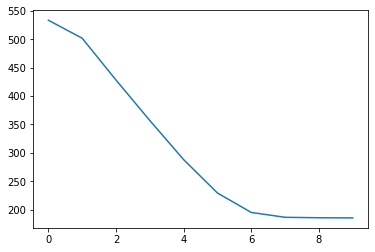

In [58]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch " + str(len(history.epoch))+f" : {history.history['loss'][len(history.epoch) - 1]}")
#fig = plt.figure(figsize=(25, 10))
plt.plot(history.history['loss'])

### Nice ;) !!

## 3 - Generating Sequence(single input without beam search)

You now have a trained model which has learned the patterns of a user tasks. You can now use this model to synthesize new Sequence! 

<a name='3-1'></a>
### 3.1 - Predicting & Sampling

<img src="images/music_gen.png" style="width:600;height:400px;">
<center><caption><b><font color='purple'>Figure 2: Generating new values in an LSTM </b></font>

#### At each step of sampling, you will:
* Take as input the activation '`a`' and cell state '`c`' from the previous state of the LSTM.
* Forward propagate by one step.
* Get a new output activation, as well as cell state. 
* The new activation '`a`' can then be used to generate the output using the fully connected layer, `densor`. 

#### Initialization
* You'll initialize the following to be zeros:
    * `x0` 
    * hidden state `a0` 
    * cell state `c0` 

In [59]:
'''
Why should we use 
 - tf.math.argmax()
 - tf.one_hot()
 - RepeatVector() ??

temp = tf.math.argmax([[4,40,4],[4,40,4]],-1)
print(temp)
temp = tf.one_hot(temp,5)
print(temp)
RepeatVector(1)(temp)

tf.Tensor([1 1], shape=(2,), dtype=int64)
tf.Tensor(
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]], shape=(2, 5), dtype=float32)
<tf.Tensor: shape=(2, 1, 5), dtype=float32, numpy=
array([[[0., 1., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.]]], dtype=float32)>'''
pass

### uniInputSequenceInferenceModel()

In [60]:
def uniInputSequenceInferenceModel(LSTM_cell, densor,Ty = 10):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        # Step 2.A: Perform one step of LSTM_cell. Use "x", not "x0" (≈1 line)
        a, _, c = LSTM_cell(inputs=x, initial_state=[a,c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = densor(a)
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, 90) (≈1 line)
        outputs.append(out)
 
        # Step 2.D: 
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        x = tf.math.argmax(out,-1)
        x = tf.one_hot(x,n_values)
        # Step 2.E: 
        # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, 90)
        x = RepeatVector(1)(x)
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model = Model(inputs = [x0,a0,c0] , outputs = outputs)
    
    
    return inference_model

In [61]:
'''
What is sequenceInferenceModel(LSTM_cell, densor) type? 
<keras.engine.functional.Functional at 0x7fcee9e5f370>'''
pass

In [62]:
uni_inference_model = uniInputSequenceInferenceModel(LSTM_cell, densor, Ty = 50)

In [63]:
uni_inference_model.input_shape

[(None, 1, 293), (None, 32), (None, 32)]

In [64]:
uni_inference_model.output_shape[0:3] # insted of 3 in fact it is 96 

[(None, 293), (None, 293), (None, 293)]

In [65]:
#inference_model.summary()

In [66]:
x_initializer = np.zeros((1, 1, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [67]:
uniModelPred  = uni_inference_model.predict([x_initializer, a_initializer, c_initializer])

1/1 [==============================] - 15s 15s/step


In [68]:
testX = X[1,0:10,:]
testX = np.expand_dims(testX,axis=0)

In [69]:
def multiInputSequenceInferenceModel(LSTM_cell, densor,Ty,Tx):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    sequence -- sequence of works you have done so far in that day

    Returns:
    inference_model -- Keras model instance
    """
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units

    # Define the input of your model with a shape 
    X = Input(shape=(Tx, n_values),name='X') #(None, Tx, n_values)

    # Tx of current sequence in other hand number of works you have done so far in that day
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0') #init
    c0 = Input(shape=(n_a,), name='c0') #init
    a = a0 
    c = c0 
    
    #no need to save generated outputs we just need last a ,c and x
    for t in range(Tx):
        #Select the "t"th time step vector from X. 
        x = X[:,t,:] #(None, n_values)
        #Use reshaper to reshape x to be (1, n_values)
        x = reshaper(x) #(None, 1, n_values)
        #Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(inputs=x, initial_state=[a,c])
        #Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)

    # So now we have new a, c
    x = tf.math.argmax(out,-1)
    x = tf.one_hot(x,n_values)
    # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, 90)
    x = RepeatVector(1)(x)

    #Create an empty list of "outputs" to later store your predicted values 
    outputs = []
    #Loop over Ty and generate a value at every time step
    for t in range(Ty):
        #Perform one step of LSTM_cell
        a, _, c = LSTM_cell(inputs=x, initial_state=[a,c])
        #Apply Dense layer to the hidden state output of the LSTM_cell
        out = densor(a)
        #Append the prediction "out" to "outputs". out.shape = (None, 90)
        outputs.append(out)
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        x = tf.math.argmax(out,-1)
        x = tf.one_hot(x,n_values)
        # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, 90)
        x = RepeatVector(1)(x)
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model = Model(inputs = [X,a0,c0] , outputs = outputs)
    
    
    return inference_model

## Use this model to develop other models

In [70]:
# 20 sec run time!!! so heavy because U most for over this!! for solution go next cells ...
multi_inference_model = multiInputSequenceInferenceModel(LSTM_cell, densor, Ty = 50,Tx = 10)

#### Prediction on multi input inference model (batchSize = 1)

In [71]:
multiModelPred = multi_inference_model.predict([testX, a_initializer, c_initializer])
np.array(multiModelPred).shape #(Ty, m, n_values) (50, 1, 293)

1/1 [==============================] - 18s 18s/step


(50, 1, 293)

#### Prediction on multi input inference model (batchSize > 1)

#### Initializing x,a,c for model 

In [72]:
testX2 = np.stack((np.squeeze(testX),np.squeeze(testX))) #(m,Tx,n_values) (2, 10, 293)
testA2 = np.zeros((2,32))  #(m,n_values) (2, 32)
testC2 = np.zeros((2,32))  #(m,n_values) (2, 32)

In [73]:
multiModelPredBatch = multi_inference_model.predict([testX2, testA2, testC2])
np.array(multiModelPredBatch).shape #(Ty, m, n_values) (50, 2, 293)

1/1 [==============================] - 0s 32ms/step


(50, 2, 293)

#### accessing prediction of training example = 0

In [74]:
np.array(multiModelPredBatch)[:,0,:].shape

(50, 293)

In [75]:
'''multi_inference_model
<keras.engine.functional.Functional at 0x7f8133e46c40>'''
pass

#### Comparing multiModelPred uniModelPred (predictions...)

In [76]:
print(np.array(multiModelPred).round(3))

[[[0.772 0.014 0.053 ... 0.    0.    0.   ]]

 [[0.772 0.014 0.053 ... 0.    0.    0.   ]]

 [[0.772 0.014 0.053 ... 0.    0.    0.   ]]

 ...

 [[0.772 0.014 0.053 ... 0.    0.    0.   ]]

 [[0.772 0.014 0.053 ... 0.    0.    0.   ]]

 [[0.772 0.014 0.053 ... 0.    0.    0.   ]]]


In [77]:
print(np.array(uniModelPred).round(3))

[[[0.006 0.005 0.006 ... 0.003 0.003 0.003]]

 [[0.016 0.009 0.011 ... 0.003 0.003 0.003]]

 [[0.082 0.02  0.031 ... 0.002 0.002 0.003]]

 ...

 [[0.772 0.014 0.053 ... 0.    0.    0.   ]]

 [[0.772 0.014 0.053 ... 0.    0.    0.   ]]

 [[0.772 0.014 0.053 ... 0.    0.    0.   ]]]


#### in this part we made a specific model for each number of inputs ... to make Beam Search Faster

In [78]:
# in this part we made a specific model for each number of inputs ... to make Beam Search Faster
models = [0]
for nOfInputs in range(1, 10):
    globals()[f"inferenceModel_{nOfInputs}Inputs"] = multiInputSequenceInferenceModel(LSTM_cell, densor, Ty = 1,Tx = nOfInputs)
    models.append(globals()[f"inferenceModel_{nOfInputs}Inputs"])

# 15 sec for building 9 models?? greate !! ;)

In [79]:
#accessing to models
print(models[1].input_shape) # access by index from models array (ex index 2 includes model with 2 input)
print(inferenceModel_1Inputs.output_shape)# access by name ...
print('----------------------------------------')
print(models[2].input_shape) # access by index from models array (ex index 2 includes model with 2 input)
print(inferenceModel_2Inputs.output_shape)# access by name ...
print('----------------------------------------')
print(models[3].input_shape) # access by index from models array (ex index 3 includes model with 3 input)
print(inferenceModel_3Inputs.output_shape)# access by name ...

[(None, 1, 293), (None, 32), (None, 32)]
(None, 293)
----------------------------------------
[(None, 2, 293), (None, 32), (None, 32)]
(None, 293)
----------------------------------------
[(None, 3, 293), (None, 32), (None, 32)]
(None, 293)


#### Prediction on multi input (1 input , 2 inputs ,... ) inference model (batchSize = 2 )

In [80]:
# 1 input model test
#init Data 
testX1 = np.stack((testX[:,1,:],testX[:,1,:])) #(m,Tx,n_values) (2, 1, 293)
testA1 = np.zeros((2,32))  #(m,n_values) (2, 32)
testC1 = np.zeros((2,32))  #(m,n_values) (2, 32)
#model
input1Model = models[1]
print('input_shape =>',input1Model.input_shape)
print('output_shape =>',input1Model.output_shape)
input1ModelPred = input1Model.predict([testX1,testA1,testC1])
#print('input1ModelPred =>',np.array(input1ModelPred))
print('input1ModelPred.shape =>',np.array(input1ModelPred).shape)

input_shape => [(None, 1, 293), (None, 32), (None, 32)]
output_shape => (None, 293)
1/1 [==============================] - 1s 879ms/step
input1ModelPred.shape => (2, 293)


In [81]:
# 2 input model test
#init Data 
temp = np.squeeze(np.stack((testX[:,1,:],testX[:,1,:])))
testX2 = np.stack((temp,temp),axis = 1) #(m,Tx,n_values) (2, 2, 293)
testA2 = np.zeros((2,32))  #(m,n_values) (2, 32)
testC2 = np.zeros((2,32))  #(m,n_values) (2, 32)
#model
input2Model = models[2]
print('input_shape =>',input2Model.input_shape)
print('output_shape =>',input2Model.output_shape)
input2ModelPred = input2Model.predict([testX2,testA2,testC2])
#print('input2ModelPred =>',np.array(input2ModelPred))
print('input2ModelPred.shape =>',np.array(input2ModelPred).shape)

input_shape => [(None, 2, 293), (None, 32), (None, 32)]
output_shape => (None, 293)
1/1 [==============================] - 1s 1s/step
input2ModelPred.shape => (2, 293)


In [82]:
# 3 input model test
#init Data 
temp = np.squeeze(np.stack((testX[:,1,:],testX[:,1,:])))
testX3 = np.stack((temp,temp,temp),axis = 1) #(m,Tx,n_values) (2, 3, 293)
testA3 = np.zeros((2,32))  #(m,n_values) (2, 32)
testC3 = np.zeros((2,32))  #(m,n_values) (2, 32)
#model
input3Model = models[3]
print('input_shape =>',input3Model.input_shape)
print('output_shape =>',input3Model.output_shape)
input3ModelPred = input3Model.predict([testX3,testA3,testC3])
#print('input3ModelPred =>',np.array(input3ModelPred))
print('input3ModelPred.shape =>',np.array(input3ModelPred).shape)

input_shape => [(None, 3, 293), (None, 32), (None, 32)]
output_shape => (None, 293)
1/1 [==============================] - 1s 1s/step
input3ModelPred.shape => (2, 293)


# Beam Search

first what is beam search . imagin you aleady have a trained model on TRM that recommends tasks in a sequence!! thats awesome! but you have two options 1- model can return(recommend) one single next work that is selected py highest probability! but if you choose highest probability in each step, it doesn't garantias us to give highest multiplied probability!! Perhaps you stsrted with low probability task but in sequence you get highest!! so we use probabilistic algorythm called Beam Search!


#### The beam width tips
The beam width B is a parameter for beam search. Large values of B yield to better result but with slower performance and increased memory. Small values of B lead to worse results but is less computationally intensive. A standard value for B is around 10

##### important note : So in general AI team recoomended you to use Sequence Reccomendation with Beam Search
or fisrt calculate Beam Search then just use first recommended task from that sequence


![Alt text](images/beam_andrew%20Ng.png)

## Beam Search Implimentation

![Alt text](images/beam_diagram.jpg)

## Beam Search Formula

![Alt text](images/beam_formula.png)

In [83]:
def indexToModelInput(indexs,n_values = 293):
    oh = tf.one_hot(indexs,n_values,axis = -1)
    sw = np.swapaxes(oh,0,1)
    return sw

In [84]:
#(tx,m) to (m,Tx,n_values)
arr = np.array([[1,2,3],[5,6,0],[5,6,0]])
indexToModelInput(arr,n_values = 9)

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.]],

       [[0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [85]:
def currentValue(matrix ,width = 3):
    fattenMatrix = matrix.flatten()
    value = fattenMatrix[np.sort((-matrix).flatten().argsort()[0:width])]
    return (np.expand_dims(value,axis=0)).T
#----------------------------------------------------------------
def LastIndexs(matrix,indexs,width = 3 ,n_values = n_values):
    sort = (-matrix).flatten().argsort()[0:width]
    try :
        newIndexs = indexs[: , np.sort(sort) // n_values] 
        newIndex = np.sort(sort) % n_values
        newIndex = np.expand_dims(newIndex,axis=0)
        newIndexs = np.concatenate((newIndexs, newIndex))
        return newIndexs
    except :
        return np.expand_dims((np.sort(sort) % n_values),axis=0)
#----------------------------------------------------------------
def epsilonFunc(epsilonType):
    if epsilonType == '32':
        epsilon = np.finfo(np.float32).eps
    if epsilonType == '64':
        epsilon = np.finfo(np.float64).eps
    if epsilonType == 'no_epsilon':
        epsilon = 0 
    return epsilon    
#----------------------------------------------------------------
def beamSearch(lastSoftmax, lastA, lastC, models, Ty_max, epsilonType = '64', show = True ,auto = True):
    #epsilon for preventing from underflow
    epsilon = epsilonFunc(epsilonType)
    # initializing indexs
    indexs = 0
    values = []
    #----------------------------------------------------------------
    for i in range(Ty_max):
        # --- hyper prameter t ---
        t = (i + 1) ** 0.7
        # ------------------------
        if i == 0 : 
            modelMatrix = lastSoftmax
            indexs = LastIndexs(modelMatrix,indexs,width = 3 ,n_values = n_values)
            zeroIndex = indexs.copy() #just for printer
        #------------------------------------------------------------    
        value = currentValue(modelMatrix ,width = 3)
        valueCopy = value.copy()
        #------------------------------------------------------------
        #select models[i+ 1] with i + 1 input ... to acive modelMatrix
        modelMatrix = models[i+1].predict([indexToModelInput(indexs,n_values),lastA,lastC]) 
        modelMatrixCopy = modelMatrix.copy() #just for printer
        if i == 0:
            value = log(value + epsilon) # preventing -inf
        modelMatrix = value + log(modelMatrix + epsilon) #epsilon for preventing -inf and log for preventing memory underflow
        values.append((value/t).tolist())
        #------------------------------------------------------------
        indexs = LastIndexs(modelMatrix,indexs,width = 3 ,n_values = n_values)
        #---------------------------Printer--------------------------
        if show :
            print('------------- step '+str(i)+' -------------')
            if i == 0:
                print('firstSoftmax.shape => \n',lastSoftmax.shape)
                print('firstSoftmax => \n',lastSoftmax)
                print('zeroIndex => \n',zeroIndex)
            print('number of model inputs =>' , i+1)   
            print('valueCopy => \n',valueCopy)
            print('modelMatrix => \n',modelMatrix) 
            print('modelMatrix.shape => \n',modelMatrix.shape)
            #print('value => \n',value)
            print('indexs => \n',indexs)
    #------------------------------------------------------------
    value = currentValue(modelMatrix ,width = 3) 
    if show :
        print('finalValue => \n',value)  
    #---------------------------------------------
    values.append((value/t).tolist())
    values = np.array(values)
    #-------- normalized beam search -------------
    swapedValues = np.swapaxes(values.copy(),0,2)
    valuesLen = swapedValues.shape[-1]
    beam_width = swapedValues.shape[1]
    row = values.argmax() // valuesLen
    col = values.argmax() %  valuesLen
    swapedValues = np.squeeze(swapedValues,axis = 0)
    autoBeamSequence = indexs.T[row,:col +1]
    #---------------------------------------------
    beamSequence = np.array(indexs)[:,value.argmax()]
    #---------------------------------------------
    if auto :
        return autoBeamSequence
    else :
        return beamSequence

In [86]:
xInit = np.expand_dims(testX[:,0,:],axis = 1) #(m,Tx,n_values) (1, 1, 293)
aInit = np.zeros((1,32))                      #(1,n) (1, 32)
cInit = np.zeros((1,32))                      #(1,n) (1, 32)
#----------------------------------------------------------------
#in this part we assume that we feed our X's to our model and thats time for generating
# Function parameters
show = True
Ty_max = 6
epsilonType = '64'
indexs = 0
lastSoftmax = models[1].predict([xInit,aInit,cInit])
lastA = np.zeros((3,32))                      #(beam_width,n) (3, 32) processed hidden state from last model
lastC = np.zeros((3,32))                      #(beam_width,n) (3, 32) processed hidden cell from last model
models = models
#----------------------------------------------------------------
sequence = beamSearch(lastSoftmax, lastA, lastC, models, Ty_max,show=False,auto = False)
sequence

1/1 [==============================] - 2s 2s/step


array([0, 0, 0, 0, 0, 0, 0])

#### A simple test for beam search ...

In [87]:
values = []
arr1 = np.array([[1,2,3]]).T
#arr1 = np.concatenate((arr1),axis=0)
#arr1 = np.concatenate((arr1,arr1),axis=0)
values.append(arr1.tolist())
values

[[[1], [2], [3]]]

In [88]:
def beamSearchTest(mat ,lastSoftmax, lastA, lastC, models, Ty, epsilonType = '64', show = True):
    #epsilon for preventing from underflow
    epsilon = epsilonFunc(epsilonType)
    # initializing indexs
    indexs = 0
    values = []
    #----------------------------------------------------------------
    for i in range(Ty):
        t = (i + 1) ** 0.7
        if i == 0 : 
            modelMatrix = lastSoftmax
            indexs = LastIndexs(modelMatrix,indexs,width = 3 ,n_values = n_values)
            zeroIndex = indexs.copy() #just for printer
        #------------------------------------------------------------    
        value = currentValue(modelMatrix ,width = 3)
        valueCopy = value.copy()
        values.append((value/t).tolist())
        #------------------------------------------------------------
        modelMatrix = mat[i]
        #------------------------------------------------------------
        modelMatrixCopy = modelMatrix.copy() #just for printer
        if i == 0:
            pass
        modelMatrix = value + modelMatrix
        #------------------------------------------------------------
        indexs = LastIndexs(modelMatrix,indexs,width = 3 ,n_values = n_values)
        #---------------------------Printer--------------------------
        if show :
            print('------------- step '+str(i)+' -------------')
            if i == 0:
                print('firstSoftmax.shape => \n',lastSoftmax.shape)
                print('firstSoftmax => \n',lastSoftmax)
                print('zeroIndex => \n',zeroIndex)
            print('number of model inputs =>' , i+1)   
            print('valueCopy => \n',valueCopy)
            print('modelMatrix => \n',modelMatrix) 
            print('modelMatrix.shape => \n',modelMatrix.shape)
            #print('value => \n',value)
            print('indexs => \n',indexs)
        #------------------------------------------------------------
    value = currentValue(modelMatrix ,width = 3)
    #---------------------------------------------
    valueCopy = value.copy()
    values.append((value/t).tolist())
    values = np.array(values)
    #-------- normalized beam search -------------
    swapedValues = np.swapaxes(values.copy(),0,2)
    valuesLen = swapedValues.shape[-1]
    beam_width = swapedValues.shape[1]
    row = values.argmax() // valuesLen
    col = values.argmax() %  valuesLen
    swapedValues = np.squeeze(swapedValues,axis = 0)
    autoBeamSequence = (indexs.T)[row,:col +1]
    #---------------------------------------------
    if show : 
        print('values=> \n' , values)
        print('finalValue => \n',value)     
    return autoBeamSequence

#### Initialized values for test ...

In [89]:
#--------------------------------------
n_values = 5
np.random.seed(seed=2)
#l1------------------------------------
a = np.random.rand(n_values).round(1)
#l2------------------------------------
a10 = np.random.rand(n_values).round(1)
a20 = np.random.rand(n_values).round(1)
a30 = np.random.rand(n_values).round(1)
#l3------------------------------------
a11 = np.random.rand(n_values).round(1)
a21 = np.random.rand(n_values).round(1)
a31 = np.random.rand(n_values).round(1)
#l4------------------------------------
a12 = np.random.rand(n_values).round(1)
a22 = np.random.rand(n_values).round(1)
a32 = np.random.rand(n_values).round(1)
#l5------------------------------------
a13 = np.random.rand(n_values).round(1)
a23 = np.random.rand(n_values).round(1)
a33 = np.random.rand(n_values).round(1)
#l6------------------------------------
a14 = np.random.rand(n_values).round(1)
a24 = np.random.rand(n_values).round(1)
a34 = np.random.rand(n_values).round(1)
#l7-------------------------------------
a15 = np.random.rand(n_values).round(1)
a25 = np.random.rand(n_values).round(1)
a35 = np.random.rand(n_values).round(1)
#l7-------------------------------------
a16 = np.random.rand(n_values).round(1)
a26 = np.random.rand(n_values).round(1)
a36 = np.random.rand(n_values).round(1)
#---------------------------------------
mat0 = np.stack((a10,a20,a30))
mat1 = np.stack((a11,a21,a31))
mat2 = np.stack((a12,a22,a32))
mat3 = np.stack((a13,a23,a33))
mat4 = np.stack((a14,a24,a34))
mat5 = np.stack((a15,a25,a35))
mat6 = np.stack((a16,a26,a36))
mat = np.stack((mat0,mat1,mat2,mat3,mat4,mat5,mat6))
#----------------------------------------------------------------
#in this part we assume that we feed our X's to our model and thats time for generating
# Function parameters
show = True
Ty = 6
epsilonType = '64'
indexs = 0
models = models
mat = mat
#----------------------------------------------------------------
lastA = None # no need to use this in test
lastC = None # no need to use this in test
#----------------------------------------------------------------
autoBeamSequence = beamSearchTest(mat ,a, lastA , lastA, models, Ty)
autoBeamSequence

------------- step 0 -------------
firstSoftmax.shape => 
 (5,)
firstSoftmax => 
 [0.4 0.  0.5 0.4 0.4]
zeroIndex => 
 [[0 2 3]]
number of model inputs => 1
valueCopy => 
 [[0.4]
 [0.5]
 [0.4]]
modelMatrix => 
 [[0.7 0.6 1.  0.7 0.7]
 [1.1 1.  0.6 1.  0.7]
 [1.2 1.3 0.9 1.2 0.5]]
modelMatrix.shape => 
 (3, 5)
indexs => 
 [[3 3 3]
 [0 1 3]]
------------- step 1 -------------
number of model inputs => 2
valueCopy => 
 [[1.2]
 [1.3]
 [1.2]]
modelMatrix => 
 [[1.7 1.3 1.6 1.3 1.3]
 [1.9 1.5 1.4 1.5 1.6]
 [1.7 1.4 1.8 1.7 1.7]]
modelMatrix.shape => 
 (3, 5)
indexs => 
 [[3 3 3]
 [0 1 3]
 [0 0 2]]
------------- step 2 -------------
number of model inputs => 3
valueCopy => 
 [[1.7]
 [1.9]
 [1.8]]
modelMatrix => 
 [[2.1 2.5 2.3 1.9 2.4]
 [2.9 2.4 2.8 2.2 2.5]
 [2.2 2.2 2.6 2.3 2.8]]
modelMatrix.shape => 
 (3, 5)
indexs => 
 [[3 3 3]
 [1 1 3]
 [0 0 2]
 [0 2 4]]
------------- step 3 -------------
number of model inputs => 4
valueCopy => 
 [[2.9]
 [2.8]
 [2.8]]
modelMatrix => 
 [[3.4 3.  3.3 3.8 

array([3, 1, 0, 2, 3, 4, 3])

diagram of beam search test on specified value ...

![Alt text](images/beam_test.jpg)

### And original beamSearch() ...

In [90]:
#--------------------------------------
n_values = 293
#------------------------------------------
xInit = np.expand_dims(testX[:,0,:],axis = 1) #(m,Tx,n_values) (1, 1, 293)
aInit = np.zeros((1,32))                      #(1,n) (1, 32)
cInit = np.zeros((1,32))                      #(1,n) (1, 32)
#----------------------------------------------------------------
#in this part we assume that we feed our X's to our model and thats time for generating
# Function parameters
show = True
Ty = 6
epsilonType = '64'
indexs = 0
lastSoftmax = models[1].predict([xInit,aInit,cInit])
lastA = np.zeros((3,32))                      #(beam_width,n) (3, 32) processed hidden state from last model
lastC = np.zeros((3,32))                      #(beam_width,n) (3, 32) processed hidden cell from last model
models = models
#----------------------------------------------------------------
sequence = beamSearch(lastSoftmax, lastA, lastC, models, Ty,show=False)
sequence

1/1 [==============================] - 0s 22ms/step


array([2, 0])

dont worry if you just saw all `zeros` vactor ... that's because of weak learning. 

---

In [91]:
models[4].input_shape

[(None, 4, 293), (None, 32), (None, 32)]

In [92]:
temp = (np.stack((testX[:,1,:])))
temp.shape
np.zeros((1,293)).shape

(1, 293)

In [93]:
x = np.zeros((1,4,293))
a = np.zeros((1,32))  #(m,n_values) (1, 32)
c = np.zeros((1,32))  #(m,n_values) (1, 32)
#----------------------------------------------------
numberOfInputs = x.shape[1]
model = models[numberOfInputs]
lastSoftmax = model.predict([x,a,c])
lastA = np.zeros((3,32))                      #(beam_width,n) (3, 32) processed hidden state from last model
lastC = np.zeros((3,32))                      #(beam_width,n) (3, 32) processed hidden cell from last model
#lastSoftmax

1/1 [==============================] - 0s 26ms/step


In [94]:
temp = np.squeeze(np.stack((testX[:,1,:],testX[:,1,:])))
testX3 = np.stack((temp,temp,temp),axis = 1) #(m,Tx,n_values) (2, 3, 293)
testA3 = np.zeros((2,32))  #(m,n_values) (2, 32)
testC3 = np.zeros((2,32))  #(m,n_values) (2, 32)
#model
input3Model = models[3]
print('input_shape =>',input3Model.input_shape)
print('output_shape =>',input3Model.output_shape)
input3ModelPred = input3Model.predict([testX3,testA3,testC3])
#print('input3ModelPred =>',np.array(input3ModelPred))
print('input3ModelPred.shape =>',np.array(input3ModelPred).shape)

input_shape => [(None, 3, 293), (None, 32), (None, 32)]
output_shape => (None, 293)
1/1 [==============================] - 0s 21ms/step
input3ModelPred.shape => (2, 293)


In [95]:
def multiInputHiddenCellSequenceInferenceModel(LSTM_cell, densor,Ty,Tx):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.

    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    sequence -- sequence of works you have done so far in that day

    Returns:
    inference_model -- Keras model instance
    """
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units

    # Define the input of your model with a shape 
    X = Input(shape=(Tx, n_values),name='X') #(None, Tx, n_values)

    # Tx of current sequence in other hand number of works you have done so far in that day
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0') #init
    c0 = Input(shape=(n_a,), name='c0') #init
    a = a0 
    c = c0 
    
    #no need to save generated outputs we just need last a ,c and x
    for t in range(Tx):
        #Select the "t"th time step vector from X. 
        x = X[:,t,:] #(None, n_values)
        #Use reshaper to reshape x to be (1, n_values)
        x = reshaper(x) #(None, 1, n_values)
        #Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(inputs=x, initial_state=[a,c])
        #Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)

    # So now we have new a, c
    x = tf.math.argmax(out,-1)
    x = tf.one_hot(x,n_values)
    # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, 90)
    x = RepeatVector(1)(x)

    #Create an empty list of "outputs" to later store your predicted values 
    outputs = []
    #Loop over Ty and generate a value at every time step
    for t in range(Ty):
        #Perform one step of LSTM_cell
        a, _, c = LSTM_cell(inputs=x, initial_state=[a,c])
        #Apply Dense layer to the hidden state output of the LSTM_cell
        out = densor(a)
        #Append the prediction "out" to "outputs". out.shape = (None, 90)
        outputs.append(out)
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        x = tf.math.argmax(out,-1)
        x = tf.one_hot(x,n_values)
        #RepeatVector(1) to convert x into a tensor with shape=(None, 1, 90)
        x = RepeatVector(1)(x)
        
    #model instance with the correct "inputs" and "outputs"
    inference_model = Model(inputs = [X,a0,c0] , outputs = [outputs,a,c])
    
    
    return inference_model

In [96]:
hiddenCellModel = multiInputHiddenCellSequenceInferenceModel(LSTM_cell, densor, Ty = 1,Tx = 4)

In [97]:
hiddenCellModels = [0]
for nOfInputs in range(1,5):
    hiddenCellModels.append(multiInputHiddenCellSequenceInferenceModel(LSTM_cell, densor, Ty = 1,Tx = nOfInputs))

In [98]:
def copyAndStack(array,beamWidth):
    matrix = np.zeros((beamWidth,array.shape[-1]))
    arange = np.arange(0,beamWidth)
    matrix[arange,:] = array.copy()
    return matrix

In [99]:
def sequenceGenerator(currentSequence,hiddenCellModels = hiddenCellModels ,beamWidth = 3,models = models):
    #----------------------------------------------------
    initA = np.zeros((1,32))  #init values (m,n_values) (1, 32) 
    initC = np.zeros((1,32))  #init values (m,n_values) (1, 32)
    #----------------------------------------------------
    numberOfInputs = currentSequence.shape[1]
    model = hiddenCellModels[numberOfInputs]
    lastSoftmax,lastA,lastC = model.predict([currentSequence,initA,initC])
    #----------------------------------------------------
    print(lastA.shape)
    lastA = copyAndStack(lastA,beamWidth)
    lastC = copyAndStack(lastC,beamWidth)
    lastSoftmax = np.squeeze(np.array(lastSoftmax),axis=0)
    #----------------------------------------------------
    sequence = beamSearch(lastSoftmax, lastA, lastC, models, Ty_max=8,show=False)
    #----------------------------------------------------
    return sequence

In [100]:
currentSequence = np.zeros((1,4,293)) # what have you done so far...
sequenceGenerator(currentSequence,hiddenCellModels = hiddenCellModels ,beamWidth = 3)

1/1 [==============================] - 1s 1s/step
(1, 32)
1/1 [==============================] - 3s 3s/step


array([0])

## Error Analysis
When obtaining a predicted y^ that is bad, one can wonder why we did not get a good prediction y*
by performing the following error analysis:

![Alt text](images/error%20analysis.png)